In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

import glob
import os
import matplotlib.pyplot as plt
import torchvision.models as models
import cv2
import pickle
import random

In [2]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.fc3 = nn.Linear(hidden_layers, output_size)
    
    def forward(self,data):
        x = F.tanh(self.fc1(data))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim = 1)
        

In [3]:
def label2onehot(label_id):
    vector = np.zeros(101)
    vector[label_id] = 1
    return vector

def onehot2label(vector):
    return np.argmax(vector)

In [4]:
def chunk(data,batch_size):
    batches = []
    x = np.arange(len(data) // batch_size + 2)*batch_size
#     print(x)
    for b,e in zip(x[0:-1],x[1:]):
        batches.append(data[b:e])
    return batches    

In [5]:
def encode_batch(minibatch):
    label_batch = []
    feature_batch_vector = []
    for label, feature in minibatch:
        label_batch.append(label)
        feature_batch_vector.append(feature.squeeze())
    return np.array(label_batch), np.array(feature_batch_vector)
    

In [6]:
def validate(test_data,net):
    correct = 0
    for label, feature in test_data:
        x = Variable(torch.FloatTensor(feature)).cuda()
        output = net(x)
        if onehot2label(output.cpu().data.numpy()) == label:
            correct += 1
    return correct / len(test_data)
        
        

In [7]:
with open("training_data.pkl","rb") as f:
    training_data = pickle.load(f)
    random.shuffle(training_data)
    
with open("test_data.pkl","rb") as f:
    test_data = pickle.load(f)

In [9]:
training_batches = chunk(training_data,128)

In [13]:
net = Classifier(4096,2048,101)
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate )
loss = nn.CrossEntropyLoss()
net.train()
net.cuda()
max_epoch = 100
test_acc = []
train_acc = []
test_loss = []
train_loss = []
for ep in range(max_epoch):
    err_sum = 0 
    for minibatch in training_batches:
        feature_label, feature_vector = encode_batch(minibatch)
        feature_tensor = Variable(torch.FloatTensor(feature_vector)).cuda()
        feature_label = Variable(torch.LongTensor(feature_label)).cuda()
        output = net(feature_tensor)
        error = loss(output, feature_label)
        err_sum += error
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
    avg_err = err_sum.cpu().data.numpy()/ len(minibatch)
    test_acc.append(validate(test_data,net))
    train_acc.append(validate(training_data,net))
    print("ep[%d]\t training acc: %f\t test acc: %f"%(ep, train_acc[-1], test_acc[-1]))

ep[0]	 training acc: 0.338350	 test acc: 0.343446
ep[1]	 training acc: 0.398801	 test acc: 0.394178
ep[2]	 training acc: 0.425245	 test acc: 0.407089
ep[3]	 training acc: 0.442711	 test acc: 0.412594
ep[4]	 training acc: 0.461470	 test acc: 0.420911
ep[5]	 training acc: 0.475808	 test acc: 0.425743
ep[6]	 training acc: 0.491689	 test acc: 0.432079
ep[7]	 training acc: 0.504060	 test acc: 0.435881
ep[8]	 training acc: 0.518766	 test acc: 0.440198
ep[9]	 training acc: 0.523651	 test acc: 0.442535
ep[10]	 training acc: 0.529711	 test acc: 0.444792
ep[11]	 training acc: 0.535599	 test acc: 0.442970
ep[12]	 training acc: 0.546556	 test acc: 0.446337
ep[13]	 training acc: 0.559296	 test acc: 0.452752
ep[14]	 training acc: 0.565224	 test acc: 0.450970
ep[15]	 training acc: 0.568867	 test acc: 0.453228
ep[16]	 training acc: 0.575904	 test acc: 0.453980
ep[17]	 training acc: 0.582941	 test acc: 0.456079
ep[18]	 training acc: 0.591390	 test acc: 0.458535
ep[19]	 training acc: 0.593555	 test acc:

In [14]:
import matplotlib.pyplot as plt
import numpy as np

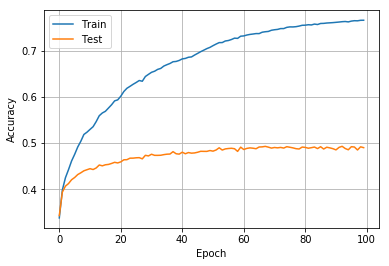

In [19]:
plt.plot(np.array(train_acc))
plt.plot(np.array(test_acc))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train","Test"])
plt.show()

In [23]:
len(training_data)  + len(test_data) 

100997